In [598]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os


In [599]:
path = kagglehub.dataset_download("clkmuhammed/autoscout24-car-listings-dataset")
df = pd.read_csv(
    os.path.join(path,"autoscout24_dataset_20251108.csv"),
    encoding='utf-8',
    sep=',',
    engine='python')

# df = pd.read_csv('../data/data_raw.csv')
# print(df.info())


In [600]:
#wstępne czyszczenie danych - zamiana na wartości numeryczne
df['weight_kg'] = df['weight_kg'].str.replace(' kg', '', regex=False)
df['weight_kg'] = df['weight_kg'].str.replace(',', '', regex=False).astype('float64')


df['mileage_km'] = df['mileage_km'].str.replace(' km', '', regex=False)
df['mileage_km'] = df['mileage_km'].str.replace(',', '', regex=False).astype('float64')

# mileage_km to to samo co mileage_km raw, można więc usunąć jedną z tych kolumn
correlation = df['mileage_km_raw'].corr(df['mileage_km'])
print(f"Korelacja między kolumnami mileage_km_raw i mileage_km: {correlation}")
 
del df['mileage_km_raw']


#przekształcenie daty rejestracji na wiek auta
df['registration_date'] = df['registration_date'].str.extract('(\d{4})').astype('float64')
df['car_age'] = 2026 - df['registration_date']
del df['registration_date']
del df['production_year']

Korelacja między kolumnami mileage_km_raw i mileage_km: 1.0


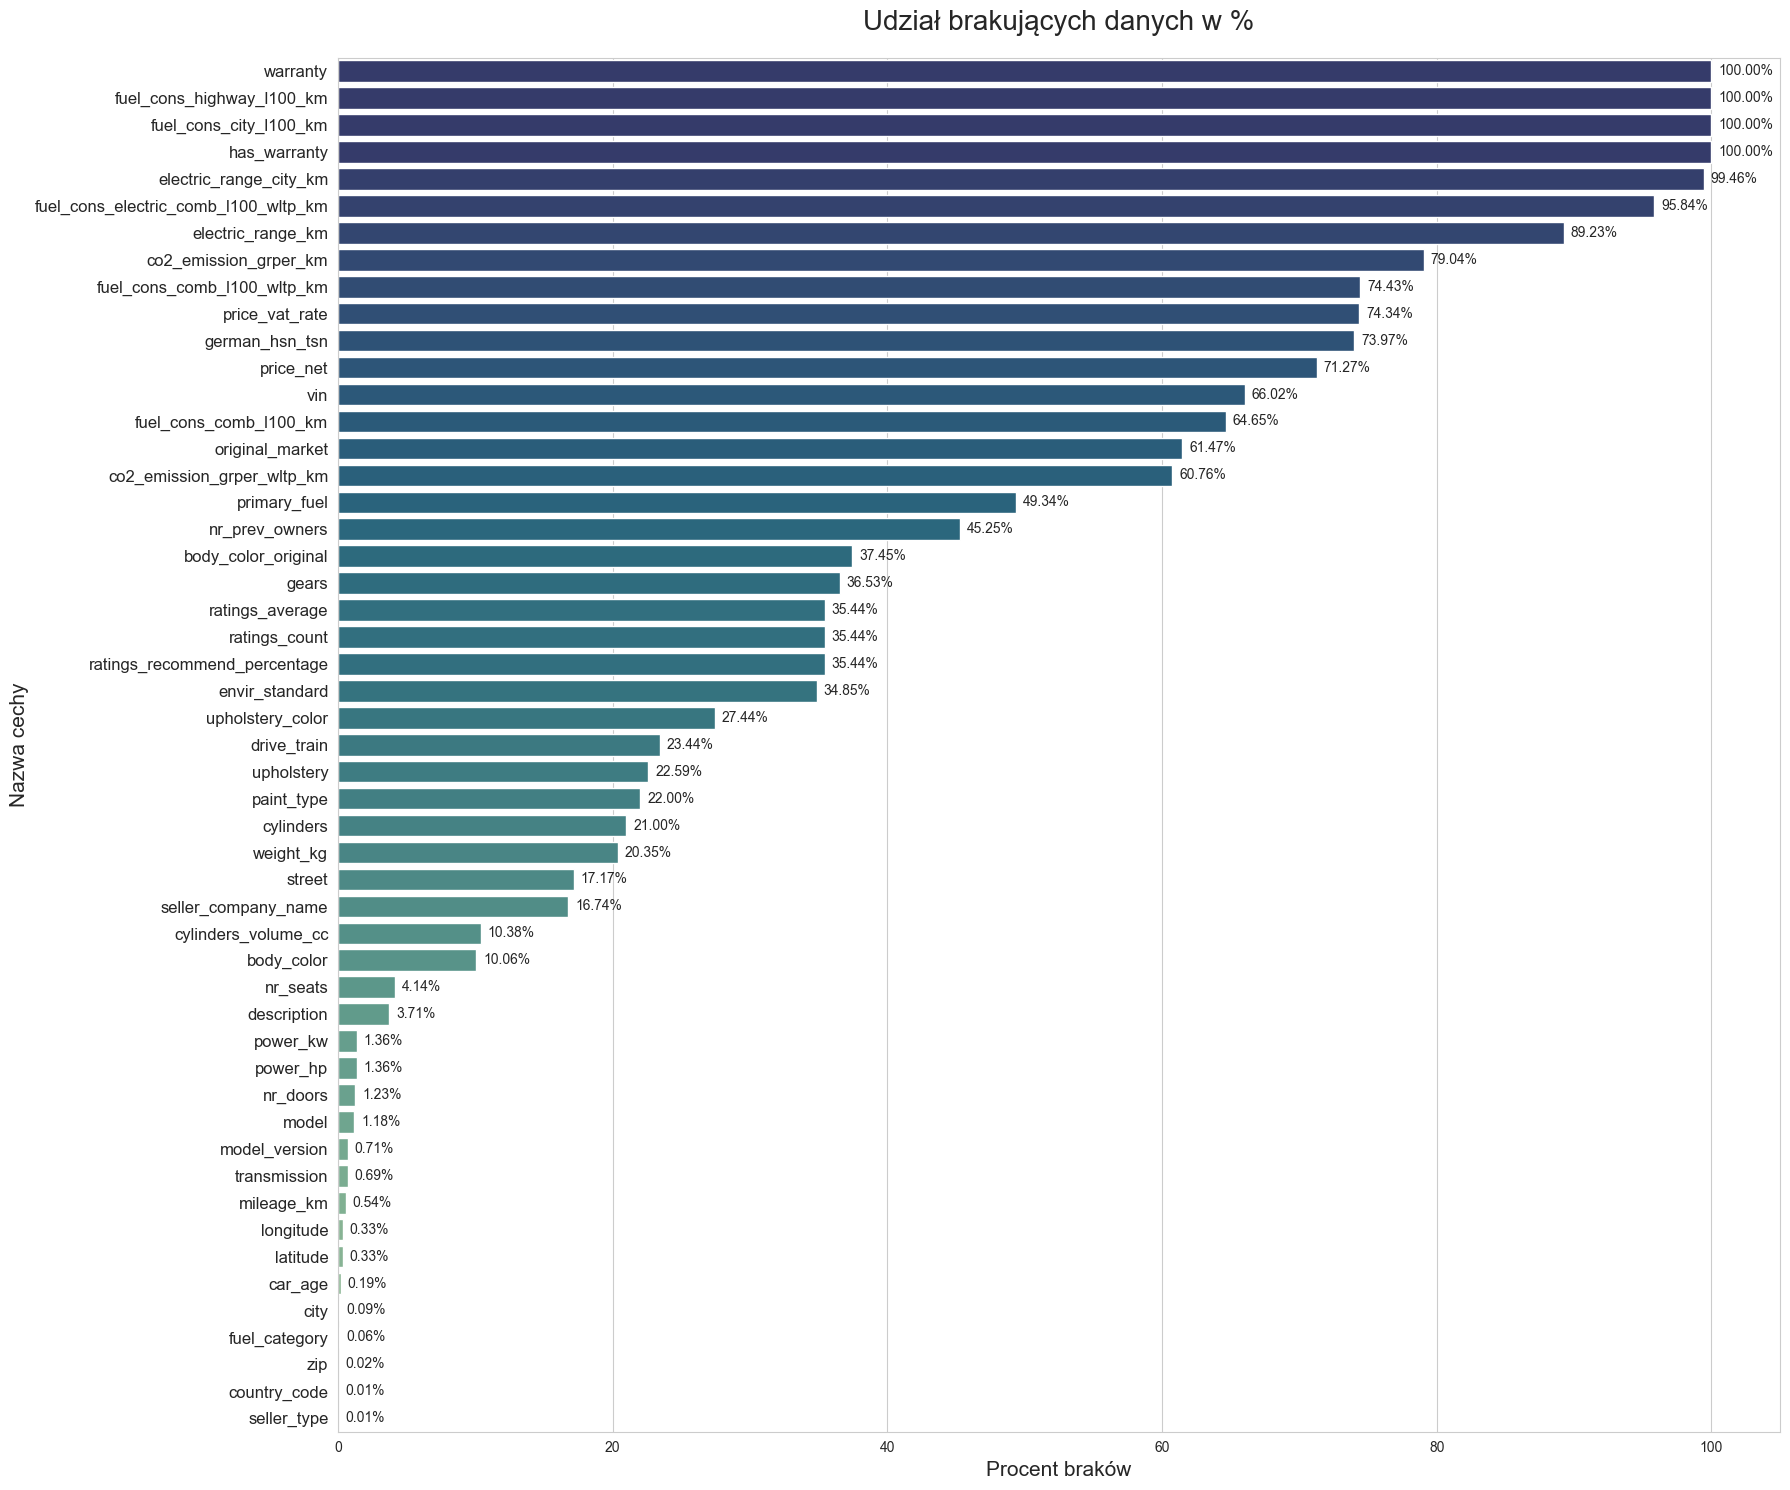

In [601]:
#brakujące dane w zbiorze

missing_data = (df.isnull().sum()/len(df)) *100
missing_data = missing_data[missing_data>0].sort_values(ascending = False).reset_index()
missing_data.columns = ["Cecha","Procent"]

plt.figure(figsize=(18,15))
sns.set_style("whitegrid")
plt.title('Udział brakujących danych w %',fontsize= 20,pad=20)
ax = sns.barplot(
    x='Procent',
    y='Cecha',
    data = missing_data,
    palette = sns.color_palette("crest",43),
    hue = 'Procent',
    legend = False
)

for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%', padding=5,fontsize= 10)

plt.yticks(fontsize=12)
plt.xlabel('Procent braków',fontsize= 15)
plt.ylabel('Nazwa cechy',fontsize = 15)
plt.tight_layout()
plt.show()

In [602]:
# kolumny fuel_cons_city_l100_km, has_warranty, warranty oraz fuel_cons_highway_l100_km są całkowicie puste, można je więc usunąć

cols_to_drop = ['fuel_cons_city_l100_km', 'has_warranty', 'warranty' ,'fuel_cons_highway_l100_km']
df.drop(columns=cols_to_drop,inplace=True)


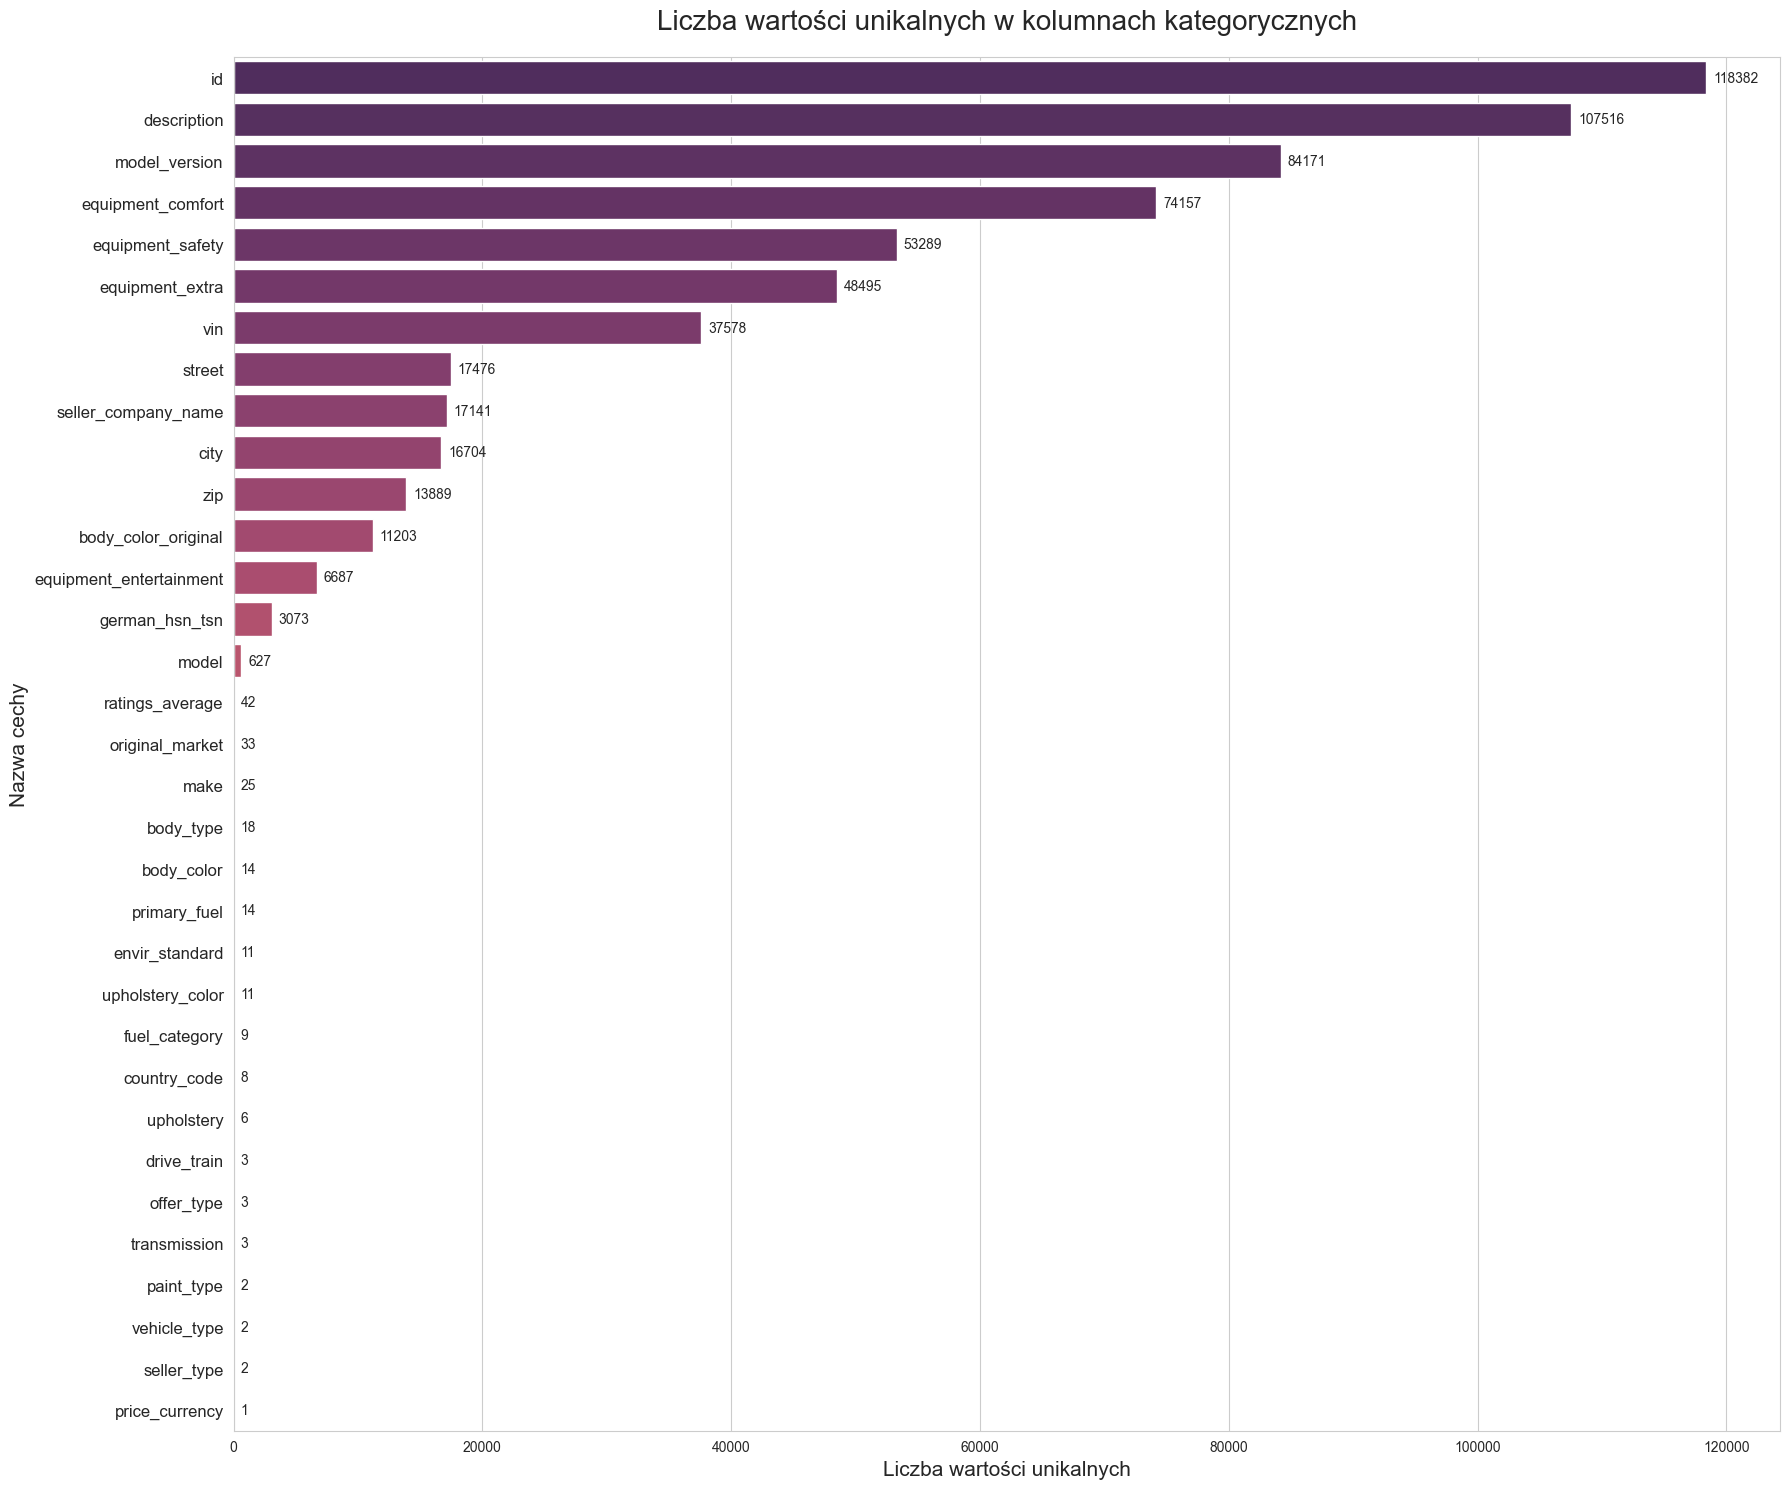

In [603]:
#wartości unikalne 

unique_counts = df.select_dtypes(include=['object']).nunique().reset_index()
unique_counts.columns = ['Cecha', 'Wartości_Unikalne']
unique_counts = unique_counts.sort_values(by='Wartości_Unikalne', ascending=False)


plt.figure(figsize=(18,15))
sns.set_style("whitegrid")
plt.title('Liczba wartości unikalnych w kolumnach kategorycznych',fontsize= 20,pad=20)
ax = sns.barplot(
    x='Wartości_Unikalne',
    y='Cecha',
    data = unique_counts,
    palette = sns.color_palette("flare",27),
    hue = 'Wartości_Unikalne',
    legend = False
)

for container in ax.containers:
    ax.bar_label(container,padding=5,fontsize= 10)

plt.yticks(fontsize=12)
plt.xlabel('Liczba wartości unikalnych',fontsize= 15)
plt.ylabel('Nazwa cechy',fontsize = 15)
plt.tight_layout()
plt.show()

        

In [604]:
# kolumna price_currency ma tylko 1 wartość (zerowa wariancja)
# kolumna id to unikatowy identyfikator i zachowanie jej dodawałoby jedynie szum
# kolumna description może wnosić ciekawe informacje do modelu, jednak wymaga bardziej zaawansowanych technik przetwarzania języka naturalnego
# vin - vechicle identification number to kolejny unikatowy identyfikator( w dodatku 66% ofert nie ma go podanego), ale zawiera w sobie informacje o modelu auta i kraju, więc może jesteśmy go w stanie wykorzystać do inputacji, jednak nie trafi on do ostatecznego modelu
# german_hsn_tsn to unikatowy identyfikator na rynku niemieckim (podobnie jak vin), zostanie potraktowany tak samo


df.drop(columns=['id', 'description','price_currency'],inplace=True)

# więcej unikalnych identyfikatorów
df.drop(columns=['model_version','street','seller_company_name','city','zip','longitude','latitude','vin','german_hsn_tsn'],inplace=True)


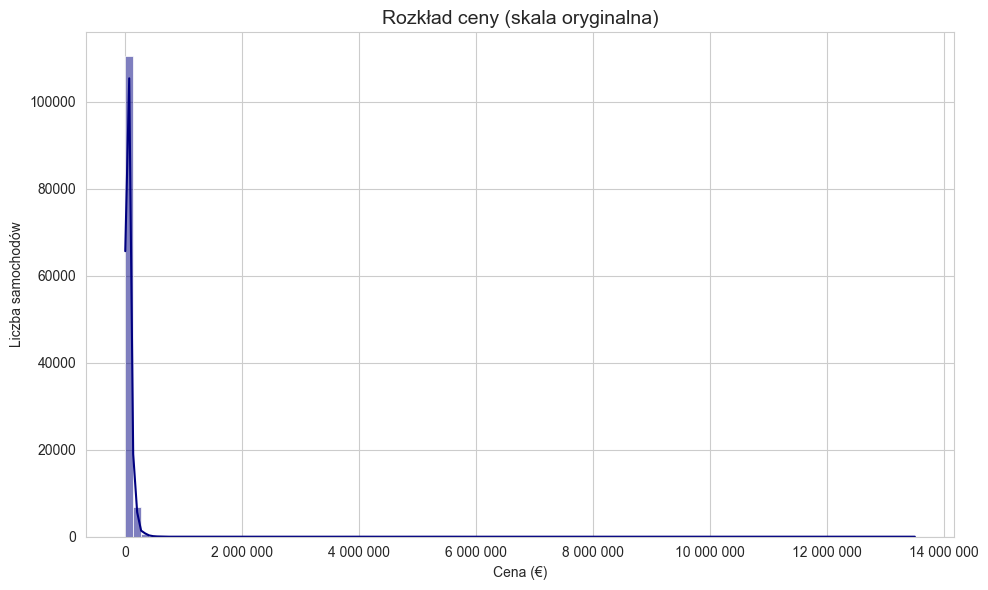

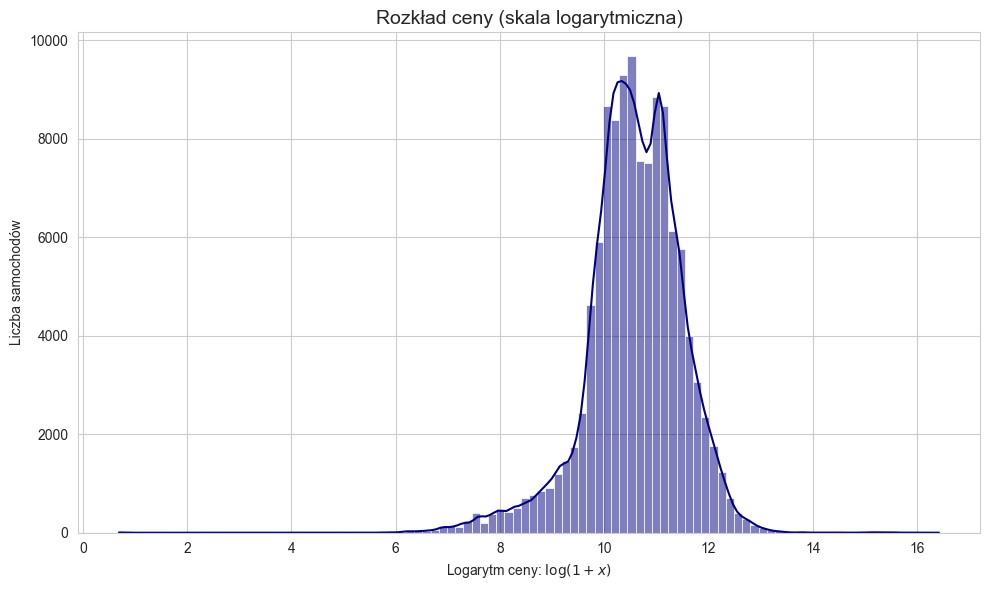

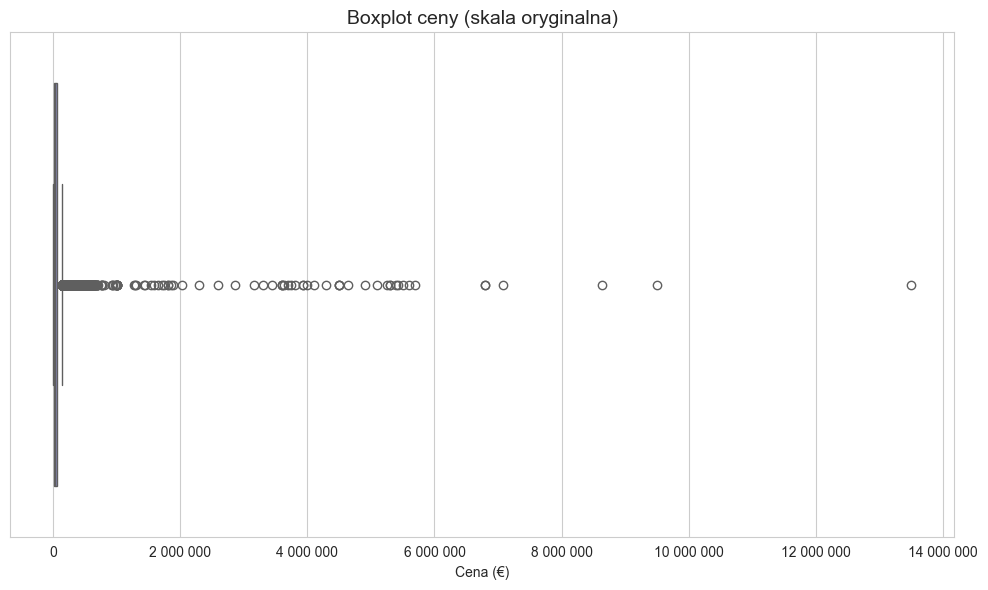

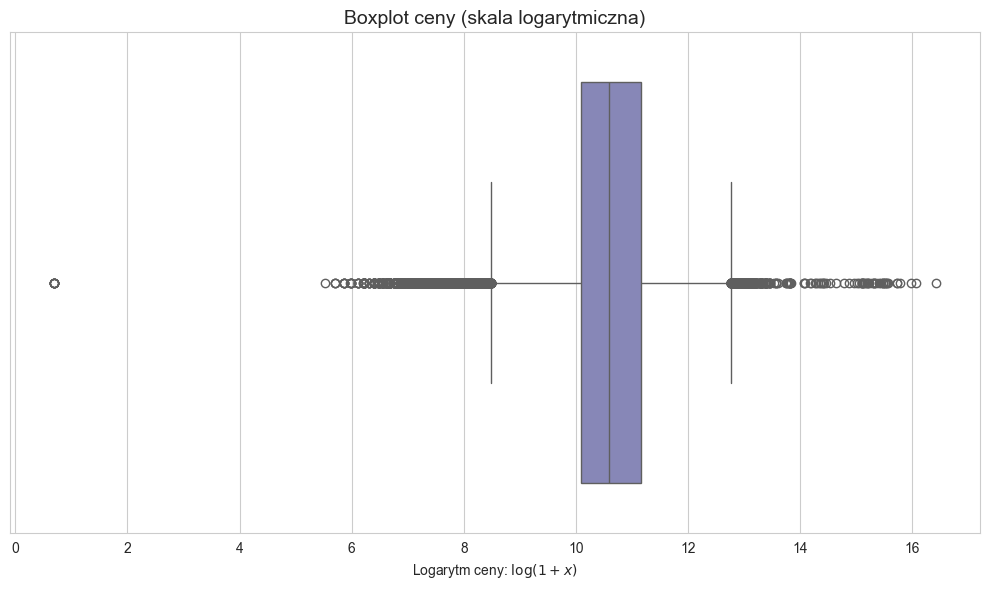

In [605]:
import matplotlib.ticker as ticker

target_column = df["price"]

# rozkład ceny - skala oryginalna
plt.figure(figsize=(10,6))
ax1 = sns.histplot(x=target_column, bins=100, kde=True, color="navy")
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'.replace(',', ' ')))

plt.title("Rozkład ceny (skala oryginalna)", fontsize=14)
plt.xlabel('Cena (€)')
plt.ylabel('Liczba samochodów')
plt.tight_layout()
plt.show()

# rozkład ceny - skala logarytmiczna
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(target_column), bins=100, kde=True, color="navy")

plt.title("Rozkład ceny (skala logarytmiczna)", fontsize=14)
plt.xlabel('Logarytm ceny: $\log(1 + x)$')
plt.ylabel('Liczba samochodów')
plt.tight_layout()
plt.show()

#boxplot - skala oryginalna
plt.figure(figsize=(10,6))
ax3 = sns.boxplot(x=target_column, color="#7f7fbf")
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'.replace(',', ' ')))

plt.title("Boxplot ceny (skala oryginalna)", fontsize=14)
plt.xlabel('Cena (€)')
plt.tight_layout()
plt.show()

# boxplot - skala logarytmiczna
plt.figure(figsize=(10,6))
sns.boxplot(x=np.log1p(target_column), color="#7f7fbf")

plt.title("Boxplot ceny (skala logarytmiczna)", fontsize=14)
plt.xlabel('Logarytm ceny: $\log(1 + x)$')
plt.tight_layout()
plt.show()

In [606]:
#data leakage - kolumna price_net 

correlation = df['price'].corr(df['price_net'])
print(f"Korelacja między kolumnami price i price_net: {correlation}")


#obserwacja - ceny w zbiorze są niezgodne z ceną netto na którą nałożony jest vat

check_cols = ['price_net', 'price_vat_rate', 'price']
df_check = df.dropna(subset=check_cols).copy()
df_check['expected_gross'] = df_check['price_net'] * (1 + (df_check['price_vat_rate']/100))
df_check['abs_error'] = (df_check['price'] - df_check['expected_gross']).abs()

total_valid = len(df_check)

#3 % to bardzo łagodny próg
broken_rows = df_check[df_check['abs_error'] > 0.03]
pct_broken = (len(broken_rows) / total_valid) * 100

print(f"Rzędny z różnicą pomiędzi ceną, a ceną netto z nałożonym podatkiem:   {len(broken_rows)} ({pct_broken:.2f}%)")


df.drop(columns=['price_net','price_vat_rate'],inplace = True)

Korelacja między kolumnami price i price_net: 0.9993408421649177
Rzędny z różnicą pomiędzi ceną, a ceną netto z nałożonym podatkiem:   23301 (90.74%)


In [607]:
#podział kolumn na boolowskie, kategoryczne, numeryczne, i kolumny zawierające listy

feature_lists = ['equipment_comfort','equipment_entertainment','equipment_extra','equipment_safety']

bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

numeric_cols = df.select_dtypes(include=["float","int"]).columns.tolist()
numeric_cols.remove("price")

categorical_cols = [col for col in df.select_dtypes(include=["object"]).columns if col not in feature_lists]



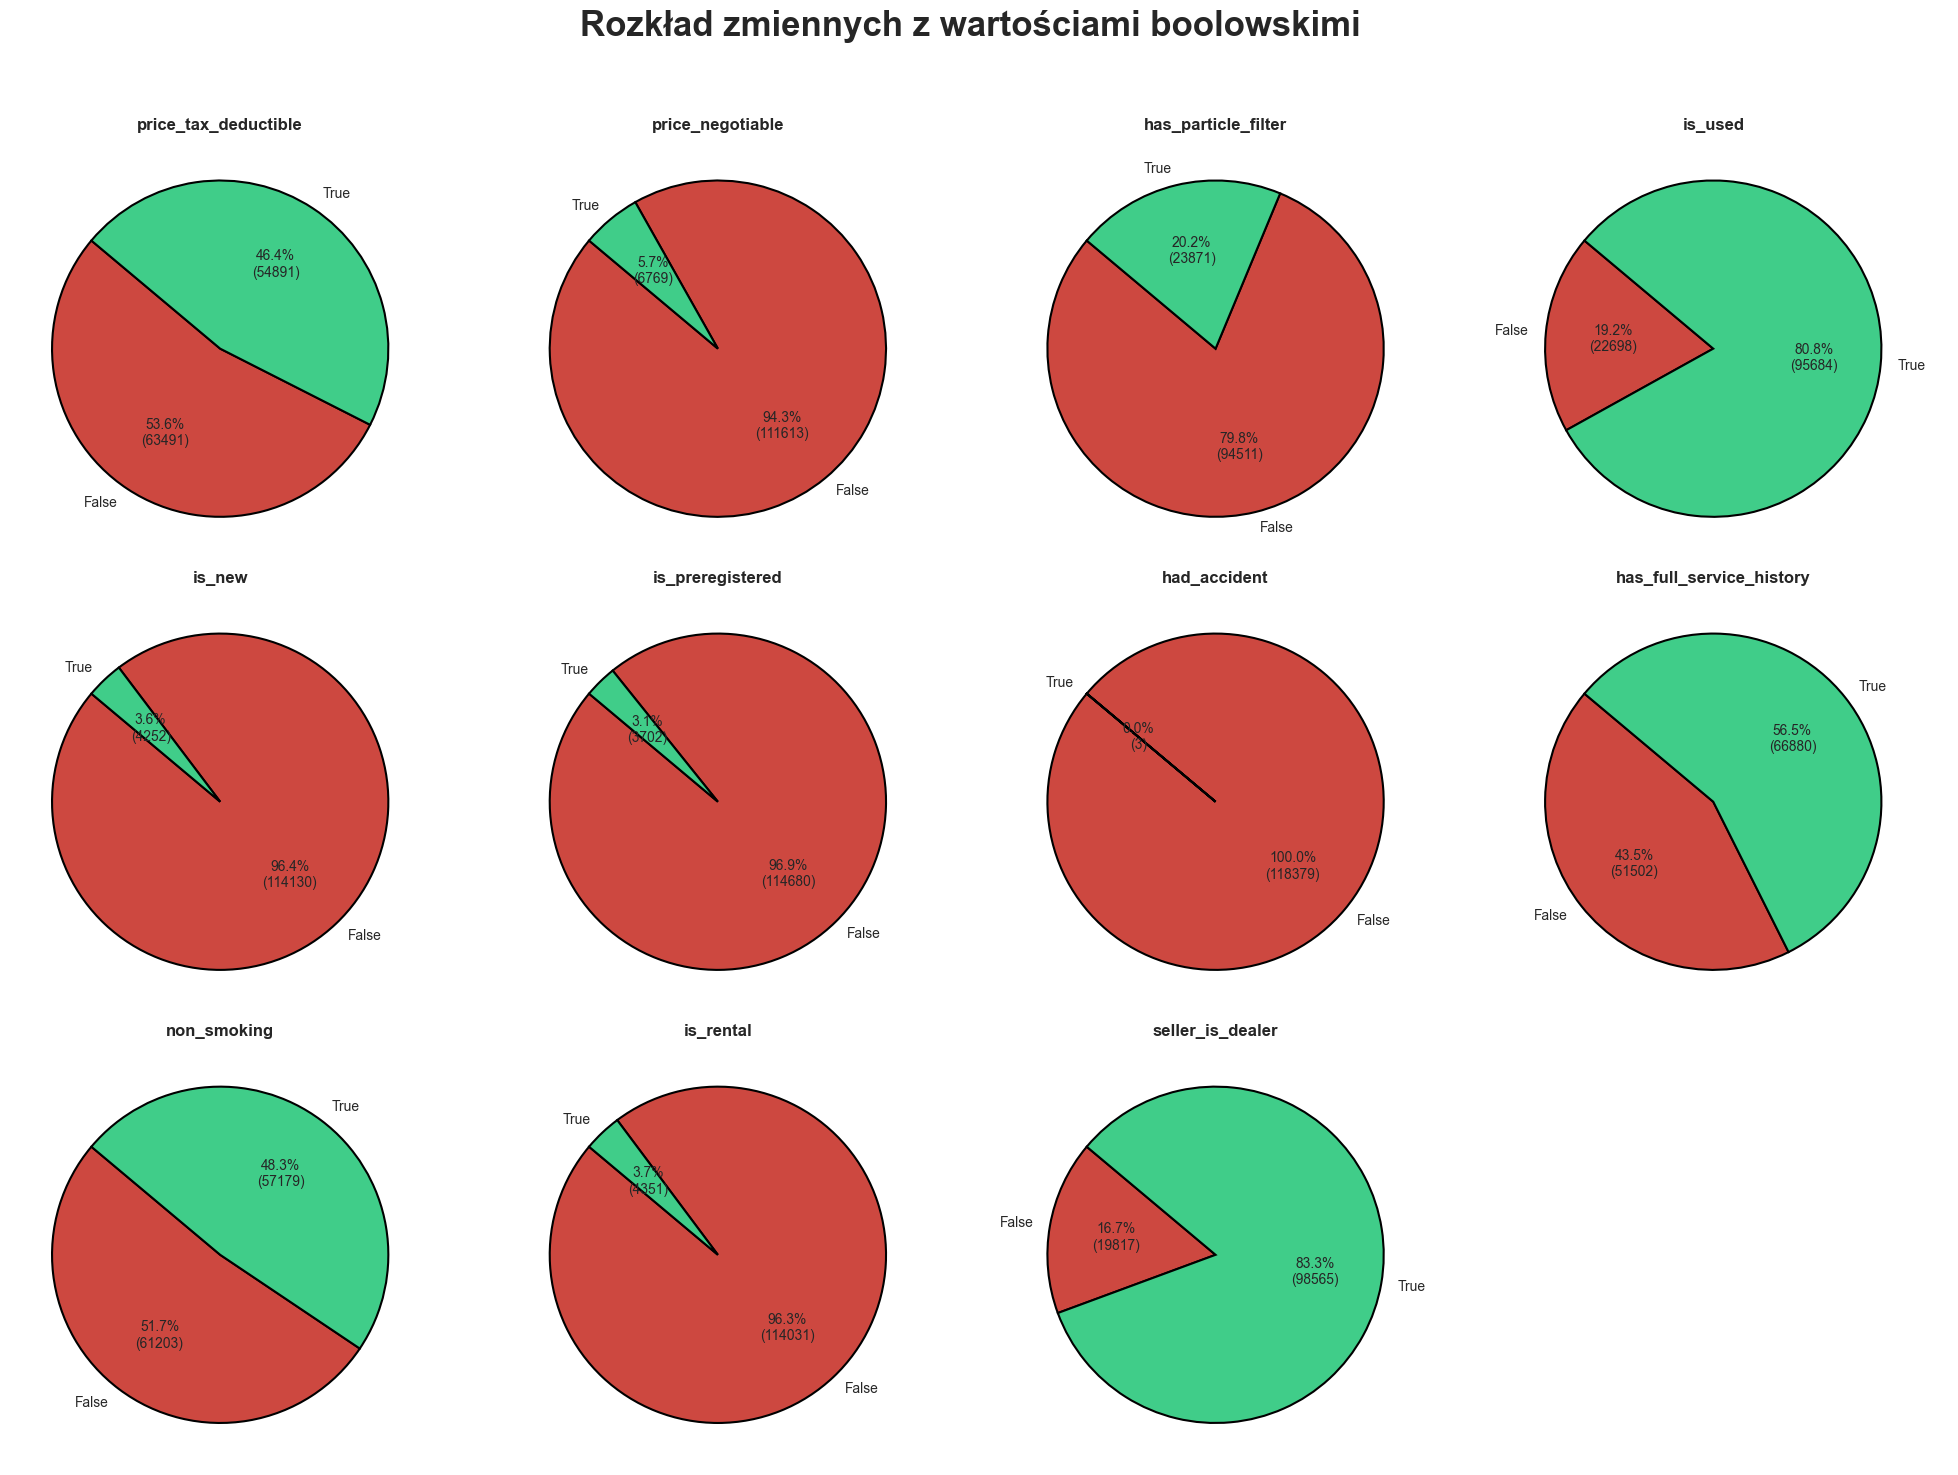

In [608]:
# pie charts dla zmiennych o wartościach boolowskich

def plot_bool_columns(dataframe, bool_cols):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle("Rozkład zmiennych z wartościami boolowskimi\n\n", fontsize=25, fontweight='bold')
    
    axes = axes.flatten()
    color_map = {True: "#40cd89", False: "#cd4840"}
    
    for i, ax in enumerate(axes):
        if i < len(bool_cols):
            col_name = bool_cols[i]
            data = dataframe[col_name].value_counts().sort_index(ascending=True)
            
            #formatowanie, by widać było i % i liczbę wartości
            def fmt(pct):
                val = int(round(pct * sum(data) / 100.0))
                return f'{pct:.1f}%\n({val:d})'

            ax.pie(
                data, 
                labels=data.index, 
                autopct=fmt,
                colors=[color_map[x] for x in data.index],
                startangle=140,
                wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
            )
            ax.set_title(col_name, fontweight='bold')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    
plot_bool_columns(df, bool_cols)           

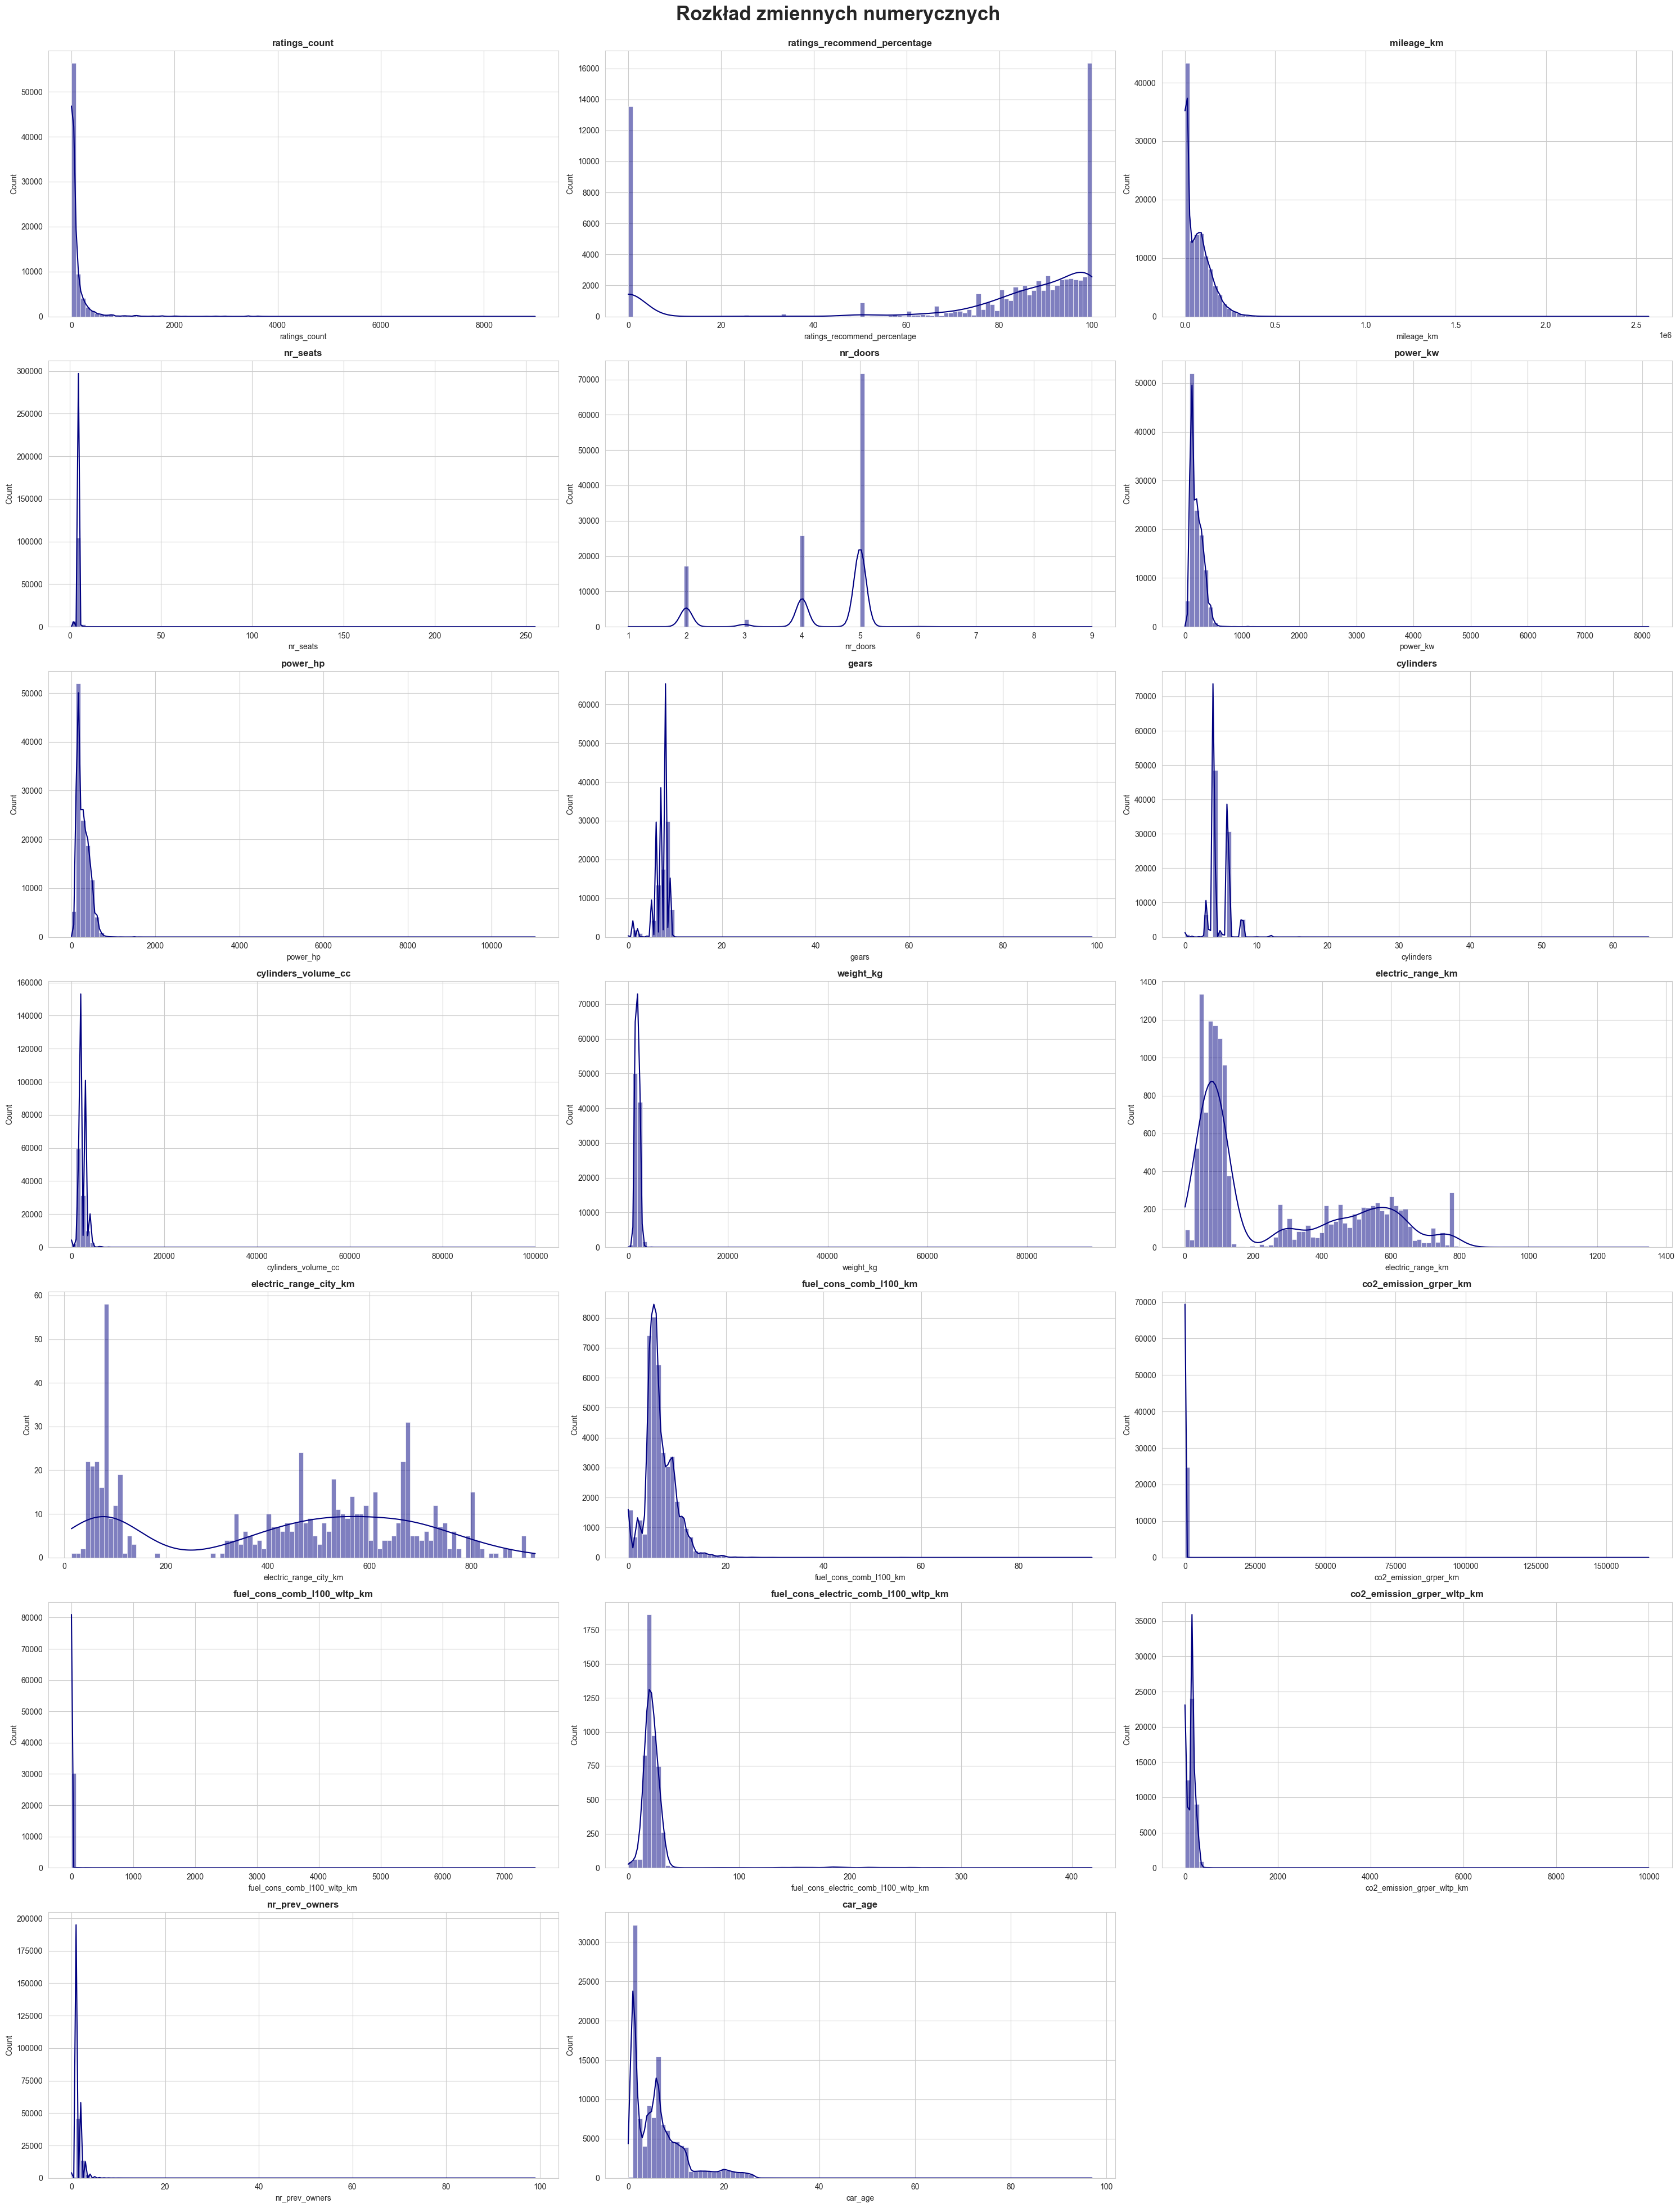

In [609]:
#histogramy dla zmiennych numerycznych

def plot_numeric_cols(dataframe, numeric_cols):
    fig, axes = plt.subplots(7, 3, figsize=(30, 40))
    fig.suptitle("Rozkład zmiennych numerycznych \n\n", fontsize=25, fontweight='bold')
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(numeric_cols):
            col_name = numeric_cols[i]        
            sns.histplot(data= dataframe,x=col_name, bins=100, kde=True, color="navy",ax=ax)
            ax.set_title(col_name, fontweight='bold')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_numeric_cols(df,numeric_cols)

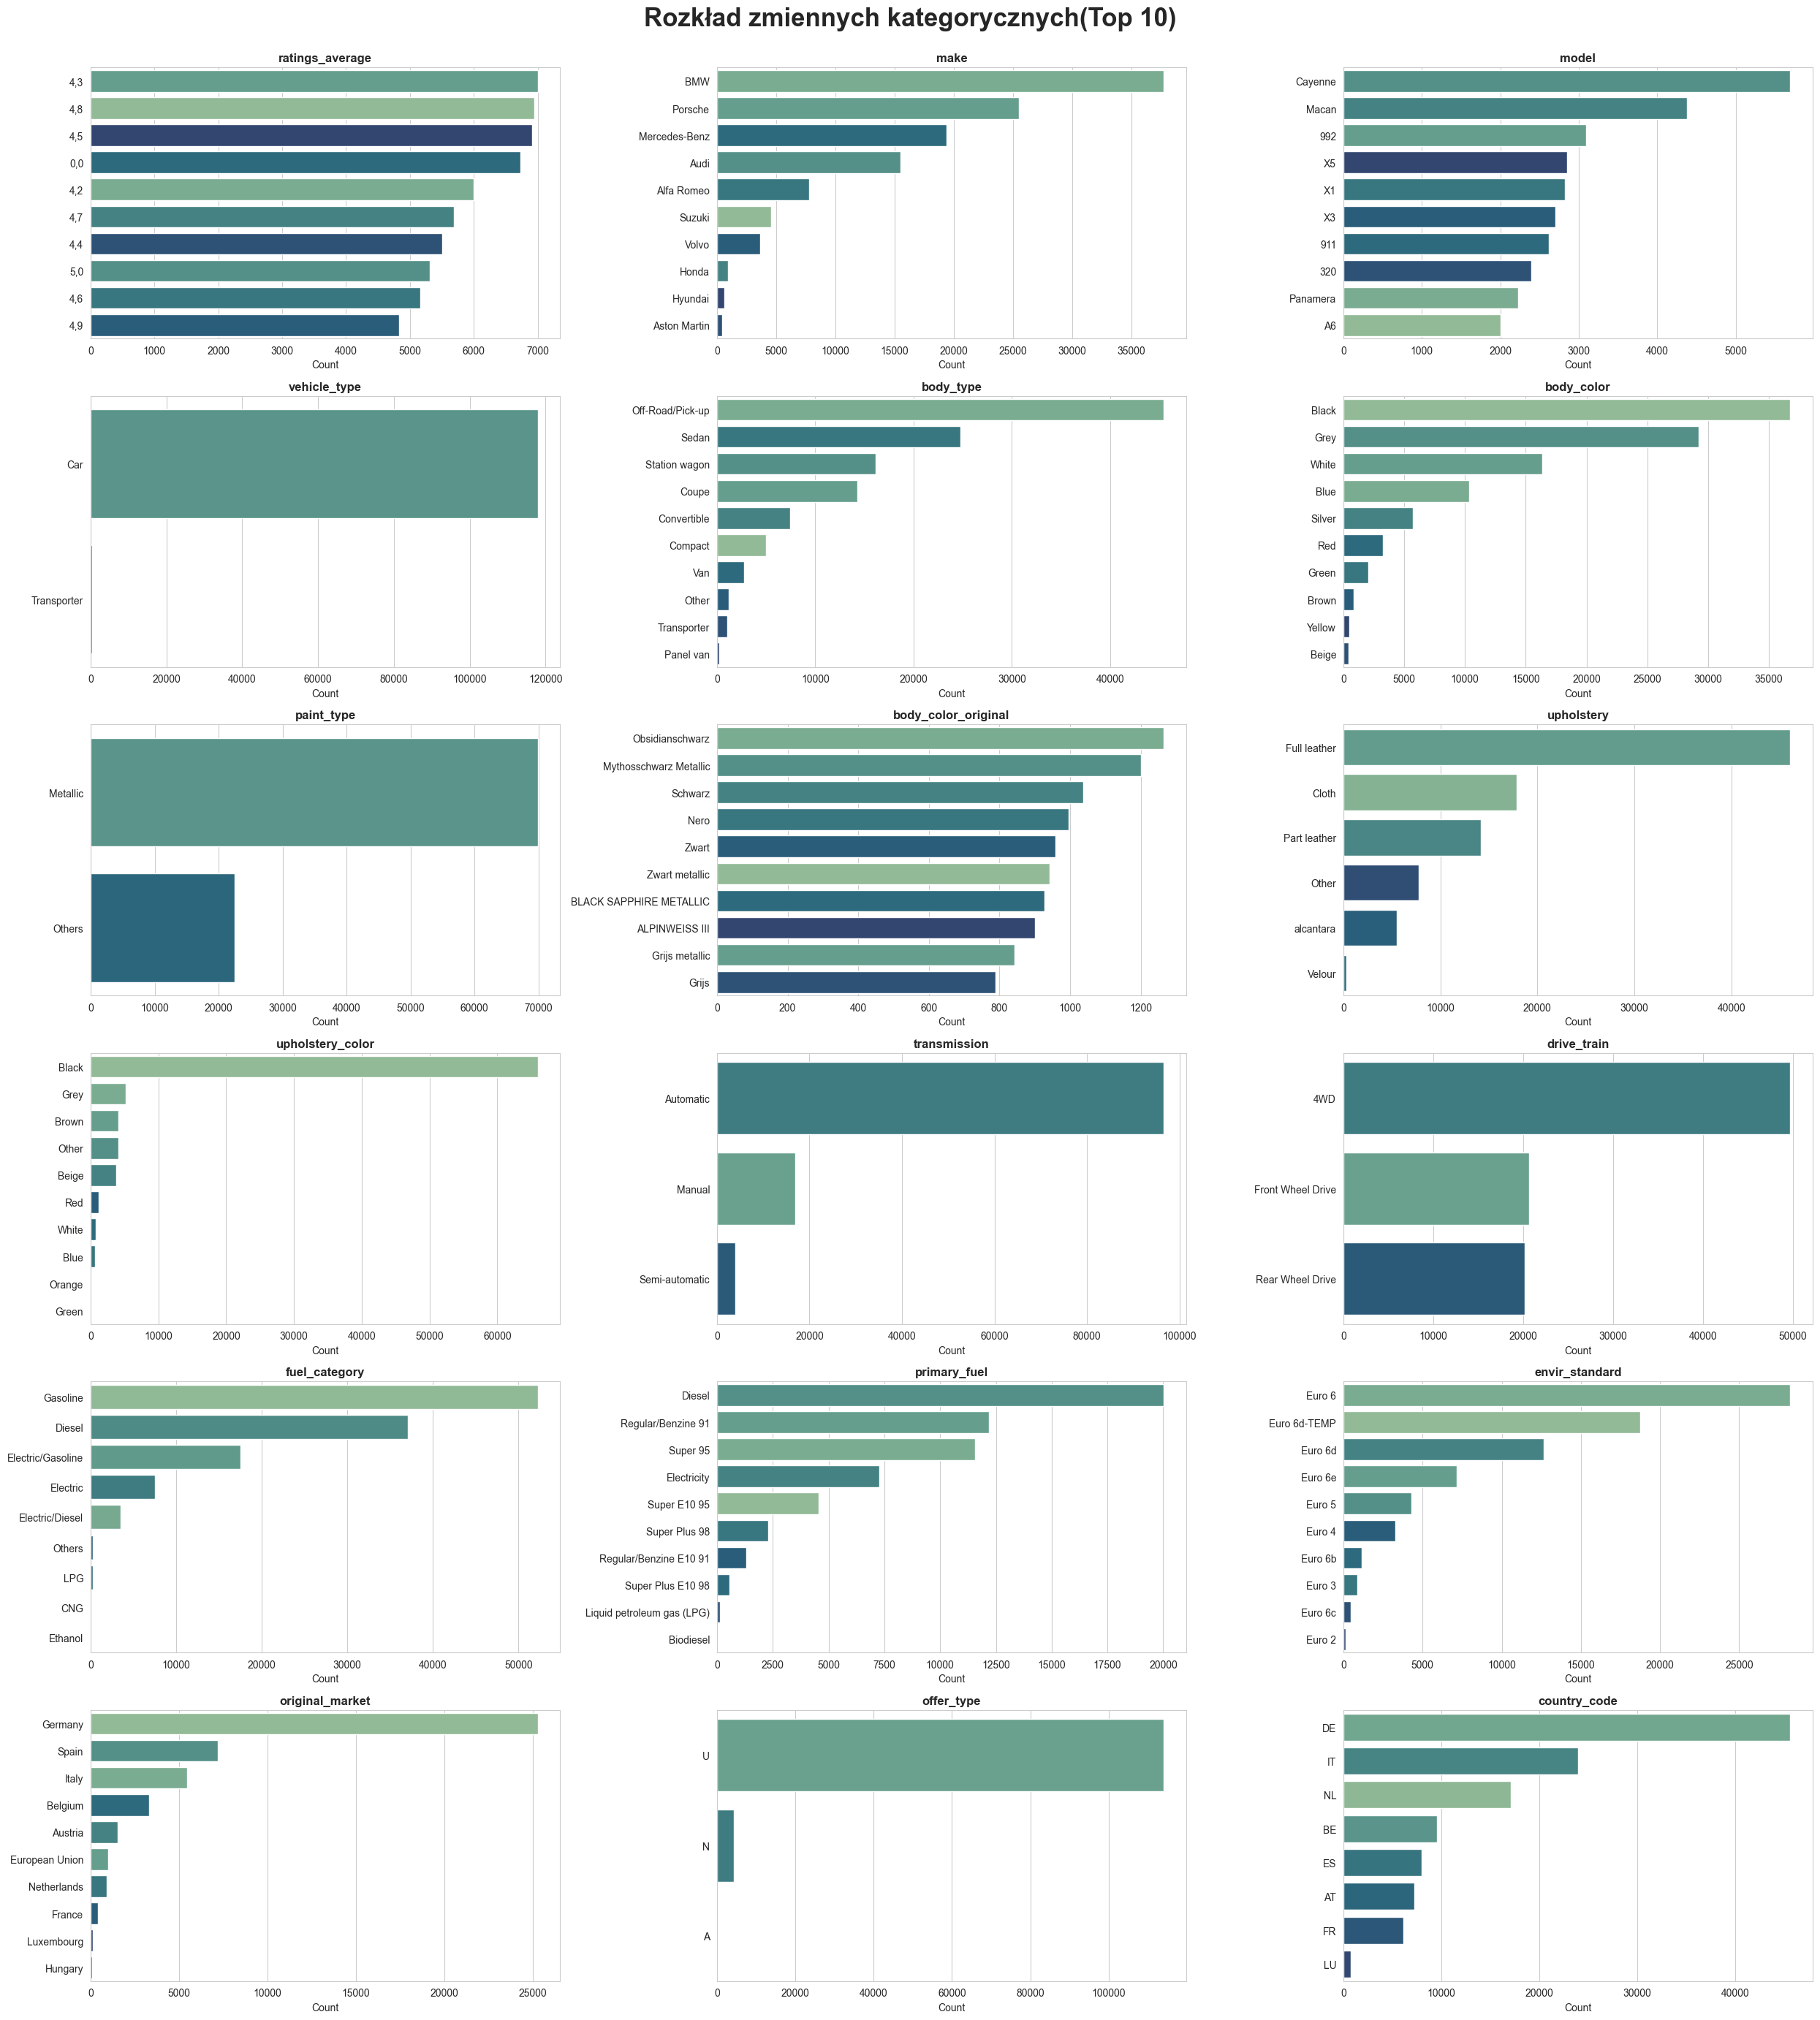

In [610]:
# wizualizacje dla zmiennych kategorycznych 

def plot_categorical_cols(dataframe, categorical_cols):

    fig, axes = plt.subplots(6, 3, figsize=(25, 30))
    fig.suptitle("Rozkład zmiennych kategorycznych(Top 10)", fontsize=25, fontweight='bold', y=0.95)
    
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(categorical_cols):
            col_name = categorical_cols[i]
            
            top_10 = dataframe[col_name].value_counts().nlargest(10).index
            
            sns.countplot(
                data=dataframe[dataframe[col_name].isin(top_10)], 
                y=col_name, 
                ax=ax, 
                order=top_10,
                palette="crest",
                hue=col_name,
                legend=False
            )
            
            ax.set_title(f"{col_name}", fontweight='bold', fontsize=12)
            ax.set_xlabel("Count")
            ax.set_ylabel(None)
            
        else:
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_categorical_cols(df, categorical_cols)

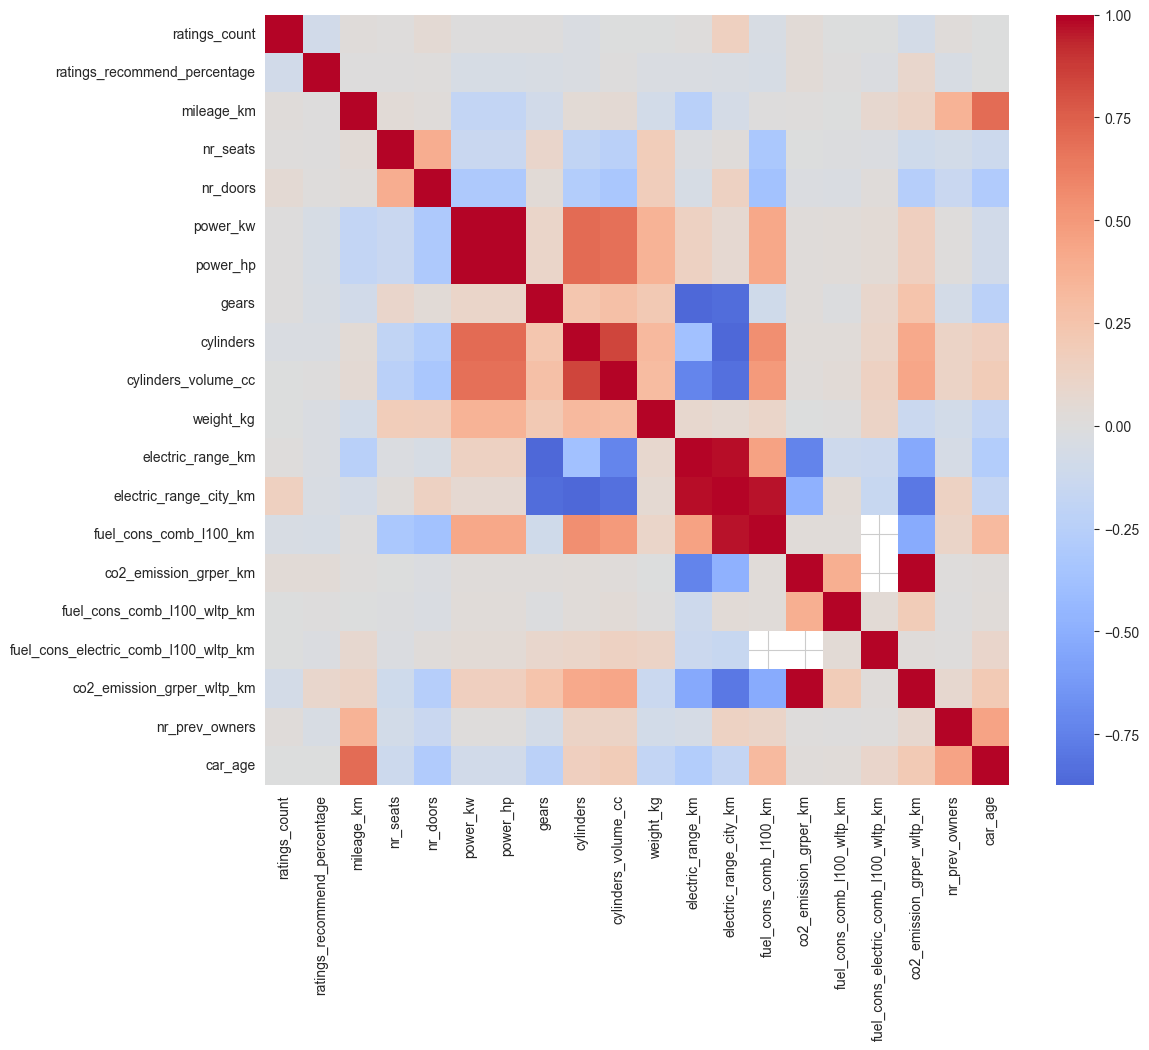

In [611]:
# korelacje między zmiennymi 

corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()


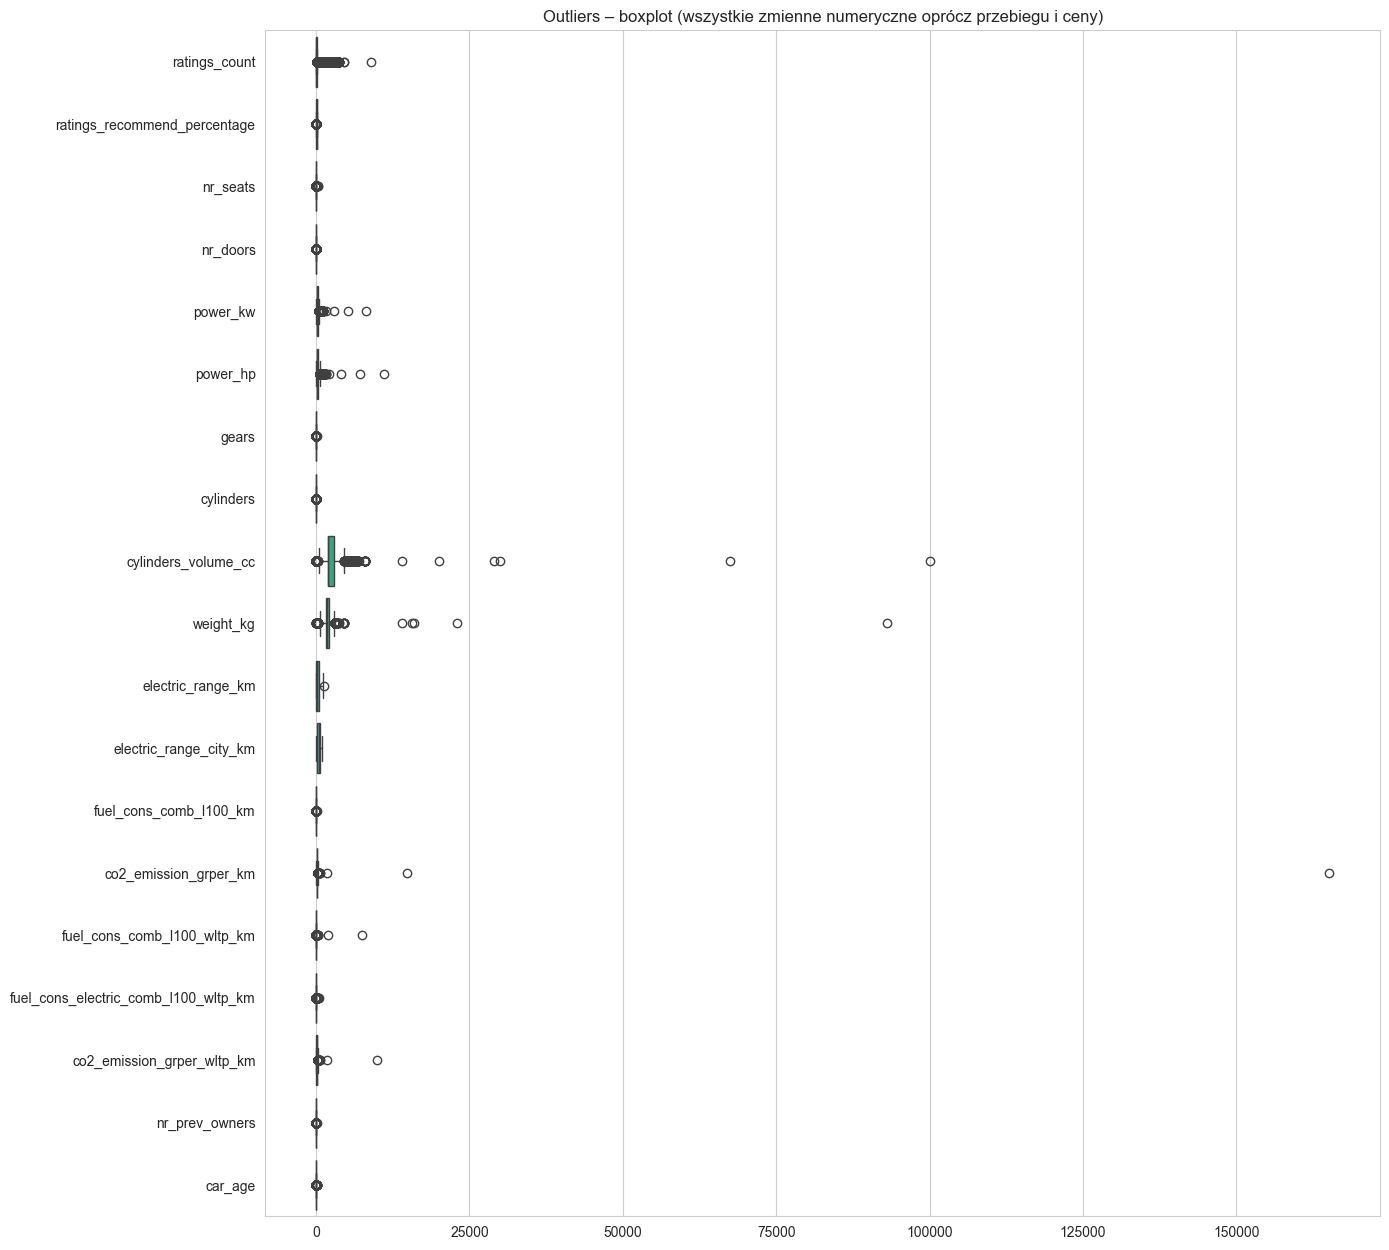

In [612]:
#Outliery

num_cols_all = df.select_dtypes(include=["int", "float"]).columns
exclude_cols = ["price", "mileage_km"]
plt.figure(figsize=(14, len(num_cols_all) * 0.6))
sns.boxplot(
    data=df[[c for c in num_cols_all if c not in exclude_cols]],
    orient="h",
    showfliers=True
)
plt.title("Outliers – boxplot (wszystkie zmienne numeryczne oprócz przebiegu i ceny)")
plt.tight_layout()
plt.show()



In [613]:
outlier_summary = []

for col in num_cols_all:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct_outliers = n_outliers / len(df) * 100

    outlier_summary.append([col, n_outliers, pct_outliers])

outliers_df = pd.DataFrame(
    outlier_summary,
    columns=["Cecha", "Liczba outlierów", "Procent [%]"]
).sort_values("Procent [%]", ascending=False)

print(outliers_df)

                                   Cecha  Liczba outlierów  Procent [%]
4                               nr_seats             25818    21.809059
5                               nr_doors             17218    14.544441
1           ratings_recommend_percentage             13895    11.737426
0                          ratings_count              8139     6.875201
2                                  price              7542     6.370901
20                               car_age              6449     5.447619
8                                  gears              2931     2.475883
10                   cylinders_volume_cc              2231     1.884577
16           fuel_cons_comb_l100_wltp_km              2170     1.833049
3                             mileage_km              1942     1.640452
19                        nr_prev_owners              1181     0.997618
9                              cylinders              1073     0.906388
7                               power_hp              1047     0

In [614]:
for col in categorical_cols:
    rare = df[col].value_counts(normalize=True)
    rare = rare[rare < 0.01]
    if not rare.empty:
        print(f"\n{col} - rzadkie kategorie:")
        print(rare)


ratings_average - rzadkie kategorie:
ratings_average
3,5    0.006594
3,4    0.004907
3,3    0.003965
3,0    0.003062
2,8    0.002682
3,1    0.002617
3,2    0.002604
1,0    0.002538
2,9    0.001439
1,8    0.001335
2,3    0.001151
2,1    0.001138
2,7    0.001112
2,6    0.001099
2,5    0.001007
1,5    0.000484
2,0    0.000445
1,9    0.000419
1,4    0.000366
2,4    0.000366
1,2    0.000314
1,6    0.000314
2,2    0.000249
1,3    0.000065
1,7    0.000065
1,1    0.000013
Name: proportion, dtype: float64

make - rzadkie kategorie:
make
Honda           0.007831
Hyundai         0.005288
Aston Martin    0.003565
Volkswagen      0.002973
BYD             0.002931
Ford            0.002551
Maserati        0.002171
Rolls-Royce     0.001960
smart           0.001613
SsangYong       0.001352
Mitsubishi      0.000650
Maybach         0.000558
Opel            0.000507
Renault         0.000507
Dongfeng        0.000422
Tesla           0.000329
Bugatti         0.000237
Kia             0.000169
Name: proportio

In [615]:
#tymczasowe zmiany, żeby nic się nie zepsuło całkowicie:

unrelated_cols = ['seller_is_dealer','seller_type','ratings_average','ratings_count','ratings_recommend_percentage']

df.drop(columns=unrelated_cols,inplace=True)

equipment_cols = ['equipment_comfort','equipment_entertainment','equipment_extra','equipment_safety']
df.drop(columns=equipment_cols,inplace=True)



In [616]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118382 entries, 0 to 118381
Data columns (total 46 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   price                                 118382 non-null  float64
 1   price_tax_deductible                  118382 non-null  bool   
 2   price_negotiable                      118382 non-null  bool   
 3   make                                  118382 non-null  object 
 4   model                                 116980 non-null  object 
 5   mileage_km                            117738 non-null  float64
 6   vehicle_type                          118382 non-null  object 
 7   body_type                             118382 non-null  object 
 8   nr_seats                              113476 non-null  float64
 9   nr_doors                              116929 non-null  float64
 10  body_color                            106471 non-null  object 
 11  

In [617]:
#zapis danych

df.to_csv('../data/data_cleaned.csv', index=False)